Motion Notebook
--------------------------

This notebook was created 2019-09-02 to look at the initial data collected for the CIMVHR study.

> Using machine learning to investigate sympathetic activation of the autonomic nervous system (SAANS) during the treatment of mild traumatic brain injury, chronic pain, and post-traumatic stress disorder.

Download all C3D files from the server to an `C3D/` directory. The list of files that have been considered is shown in `files`. Add or modify files to this list, as required. Select which file to load from `files` by setting `FILE_INDEX`.

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import stress

# interactive figures
# %matplotlib notebook
%matplotlib inline



TRIAL = '20190617_1300'
FILE_INDEX = 0

# load ECG data
files = {
    '20151215_0900': [
        '20151215_0900_DIG_TR01.c3d',
        '20151215_0900_DS_FPSTATIC_TR01.c3d',
        '20151215_0900_DS_V02_TR01.c3d',
        '20151215_0900_DS_V03_TR01.c3d',
        '20151215_0900_DS_V04_TR01.c3d',
        '20151215_0900_DS_V05_TR01.c3d',
        '20151215_0900_DS_V06_TR01.c3d',
        '20151215_0900_DS_V07_TR01.c3d',
        '20151215_0900_DS_V08_TR01.c3d',
        '20151215_0900_FP_TEST001.c3d',
        '20151215_0900_LG_V02_TR01.c3d',
        '20151215_0900_LG_V03_TR01.c3d',
        '20151215_0900_LG_V04_TR01.c3d',
        '20151215_0900_LG_V05_TR01.c3d',
        '20151215_0900_LG_V06_TR01.c3d',
        '20151215_0900_LG_V07_TR01.c3d',
        '20151215_0900_LG_V08_TR01.c3d'],
    
    '20180821_1300': ['20180821_1300_RELAX_TR01.c3d', '20180821_1300_STATIC_TR01.c3d'],
    
    '20180910_0900': [
        '20180910_0900_G1_RELAX_TR01.c3d',
        '20180914_0900_G1_RELAX_TR01.c3d',
        '20180918_0900_G1_STATIC_TR01.c3d'], 
    
    '20180928_1330': ['20180928_1330_G1_RELAX_TR01.c3d'],
    '20181026_1430': ['20181026_1430_STATIC_TR01.c3d'],
    '20181101_1430': ['20181101_1430_STATIC_TR01.c3d'],
    '20181106_1330': ['20181106_1330_STATIC_TR01.c3d'],
    
    '20181205': ['20181205_STATIC_TR01.c3d'],
    
    '20190405': [
        '20190405_STATIC_TR01.c3d',
        '20190409_STATIC_TR01.c3d',
        '20190409_STATIC_TR02.c3d'],
    
    '20190614_1100': [
        '20190614_1100_CCOP_ML_TR01.c3d',
        '20190614_1100_ER_OKS_RIGHT_TR02.c3d',
        '20190614_1100_ER_OKS_RIGHT_TR03.c3d',
        '20190614_1100_ER_OKS_TR01.c3d',
        '20190614_1100_HIT_CIRCLE_TR01.c3d',
        '20190614_1100_HIT_CIRCLE_TR02.c3d',
        '20190614_1100_STATIC.c3d'],
    
    '20190617_1300': [
        '20190617_1300_BREAK_OUT_TR01.c3d',
        '20190617_1300_CCOP_ML_TR01.c3d',
        '20190617_1300_HIT_CIRCLE_TR01.c3d',
        '20190617_1300_OKS_RIGHT_TR01.c3d',
        '20190617_1300_STATIC_TR01.c3d'],
}
filename = 'C3D/' + files[TRIAL][FILE_INDEX]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we load the data and manually examine the C3D file headers to check the
information matches what we expect: force plate data is in the same order, marker set matches.

There is minimal checking during the processing so this is an important quality control step. There are small variations on every file which we would like to reduce or remove. In the mean time "Garbage in, garbage out!"

In [2]:
print('loading '+filename+'...')
labels, markerset, (fs_point, fs_force), frames = stress.read_c3d(filename, print_metadata=True)

loading C3D/20190617_1300_BREAK_OUT_TR01.c3d...
25559 frames in 255.6 sec (00:04:15.6) at 100 Hz; analog data sampled at 1000 Hz


Header information:
  parameter_block: 2
      point_count: 57
     analog_count: 120
      first_frame: 1
       last_frame: 25560
          max_gap: 0
     scale_factor: -0.009999999776482582
       data_block: 23
 analog_per_frame: 10
       frame_rate: 100.0
long_event_labels: 0
      label_block: 0

ANALOG.DESCRIPTIONS: 1200B [100, 12]
ANALOG.DESCRIPTIONS[0] = b'Bertec Force Plate [1]                                                                              '
ANALOG.DESCRIPTIONS[1] = b'Bertec Force Plate [1]                                                                              '
ANALOG.DESCRIPTIONS[2] = b'Bertec Force Plate [1]                                                                              '
ANALOG.DESCRIPTIONS[3] = b'Bertec Force Plate [1]                                                                              '
ANALOG.DES

Next we extract the data from the file and use it to
calculate the center of pressure (COP) which is trivial given the
forces and moments (6 numbers) from each of the two force plates.
In total the 2 force plates give us 12 measurements ($F_x, F_y, F_z, M_x, M_y, M_z$ twice).
We combine the two force plates so we can take the COP together. In this case, we
take the two force plates together by adding the forces and moments.

The math is quite easy:

$\displaystyle x = \frac{M_x}{F_z}$ 

$\displaystyle y = \frac{M_x}{F_z}$

Sign changes would be due to force plate configuration where the axes might not be set up as a right-hand rule coordinate system.

We also calculate the magnitude and angle of the force vector originating at the COP over the force plate where

$ ||F||_2 = \sqrt{F_x^2 + F_y^2 + F_z^2}$

and the angles are relative to a up at 180° ($-z$ is down) taken along the $x$- and $y$-axes.

$\displaystyle \theta_x = tan^{-1}\frac{F_x}{-F_z} +180°$

$\displaystyle \theta_y = tan^{-1}\frac{F_y}{-F_z} +180°$

For convienience, we calculate the vector so small angles away from gravity are small by leaving off the +180° and thus avoid needing to do any phase unwrapping as the angle oscillates near vertical.

Marker data is captured at 100 Hz but the force plates capture data at 1000 Hz. We lowpass filter at 10 Hz and decimate to get 100 Hz force plate data.

decimating 10 (1000 Hz down to 100 Hz) after 10 Hz lowpass filter


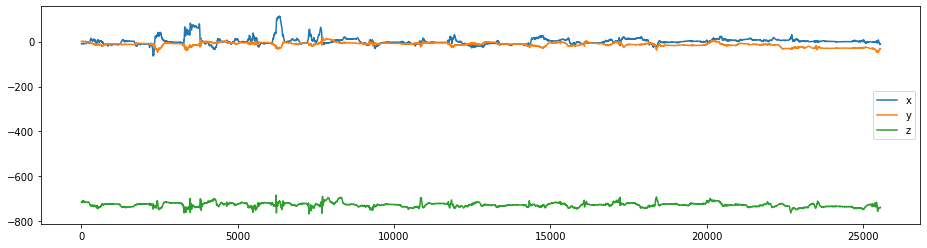

COP  start ( +2.22, +745.58) mm, 713.80 N (  -0.8°,   +0.1°)+180° = 72.8 kg (160.5 lbs)
COP    end (-76.97, +753.60) mm, 738.94 N (  -0.9°,   -2.5°)+180° = 75.4 kg (166.1 lbs)


In [3]:
# print_frames(filename, 1)
points, analog = stress.extract_frames(filename)
# print(np.shape(points))

# filter with 10 Hz low-pass filter on forces and moments, for example
#  Mansfield and Inness. Force Plate Assessment of Quiet Standing 
#  Balance Control: Perspectives on Clinical Application Within Stroke Rehabilitation. 
#  Rehabilitation Process and Outcome 2015:4 7–15 doi:10.4137/RPO.S20363.
analog_filt, fs = stress.filter_force_plates(analog, fc=10, fs_force=fs_force, fs_point=fs_point)


avg = stress.combine_force_plates(analog_filt)  # combine force plates by summing forces and moments

plt.clf()
plt.plot(avg[:,0], label='x')
plt.plot(avg[:,1], label='y')
plt.plot(avg[:,2], label='z')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(15.75, 4)
plt.show()

cop = np.array([*stress.calc_cop(avg), stress.calc_vec(avg)[0]]).transpose()
force = np.array([stress.calc_vec(analog_filt[:,0:3])[0], stress.calc_vec(analog_filt[:,6:9])[0]]).transpose()

stress.print_cop_vec(avg, prefix='%6s'%('start'), frame_num=0)
stress.print_cop_vec(avg, prefix='%6s'%('end'), frame_num=-1)

We create a crude skeleton from the markers by drawing lines between them.
This is no where near what it should be, but at least it helps us to visualize whats happening during the session.

Normally the process would be to fit a skeleton to the markers.

A frame of the marker data is plotted in large format below, with marker names annotated on the plot. Markers are in red, and blue lines are assigned based on the `skel` structure in the following code.

There are some crude checks to find markers with bad data or markers expected by `skel` but missing from the `c3d` file.

markerset: 0_MPL_FULL_BODY_57markers_V2
  LFHD <missing from c3d>


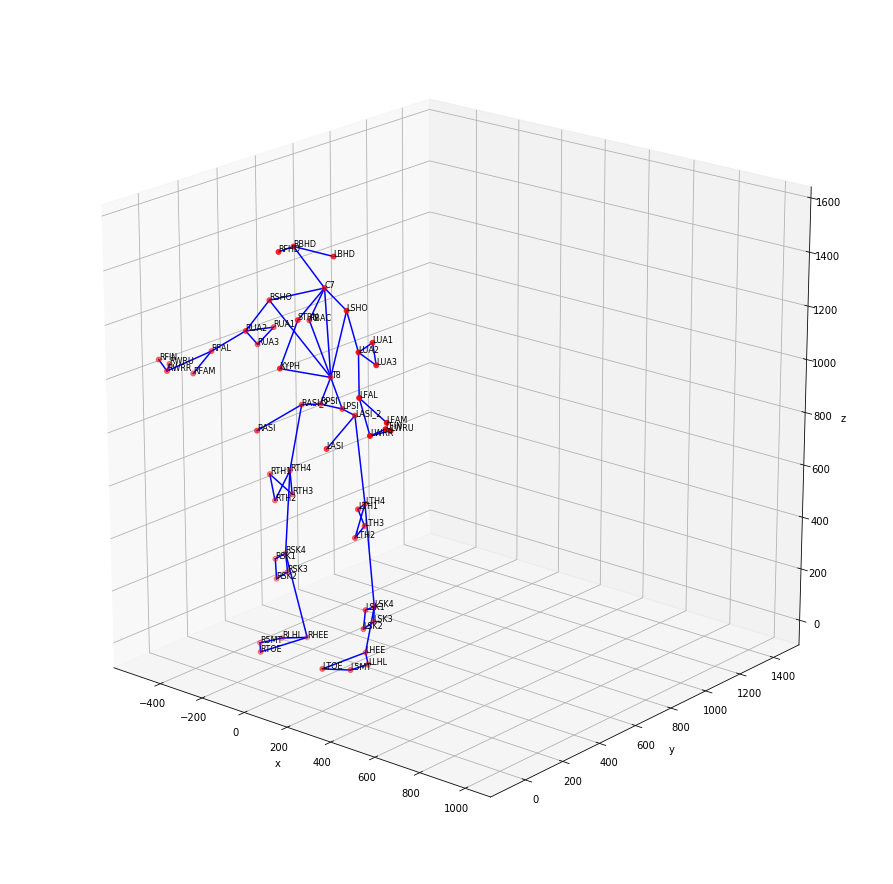

In [14]:
print('markerset: ' + markerset)
skel = stress.load_markerset(markerset)

frame_num = int(0*fs)


missing, cause = stress.check_c3d_markers(skel, labels)
dropped = stress.find_dropped_markers(points, labels, frame_num=frame_num)
skel_idx = stress.skel_to_ids(skel, labels, dropped_or_missing=set(dropped | missing))

for a in missing:
    print('%6s <missing from %s>' % (a, cause[a]))
for a in dropped:
    print('%6s <dropped marker>' % (a))


plt.clf()

ax = plt.subplot(projection='3d')
ax.view_init(20, -50)
stress.plot_skel(skel_idx, points, frame_num=frame_num, labels=labels, node_size=24)


fig = plt.gcf()
fig.set_size_inches(15.75, 16)
#fig.set_size_inches(8, 8)
plt.show()

We plot the Centre of Pressure (COP) and left/right forces using the force plate data, along with the motion capture markers after assigning a curde skeleton to the markers.

We mark the current frame (shown for the skeleton/marker data), as a vertical dashed line on the left/right force plates, and as a red dot on the COP plot.

You can select a new frame to plot by setting `frame_num`.

∥F∥ = 686.6 N   to 769.3 N
∥F∥ = 154.3 lbs to 172.9 lbs
median subject weight: 163.5 lbs


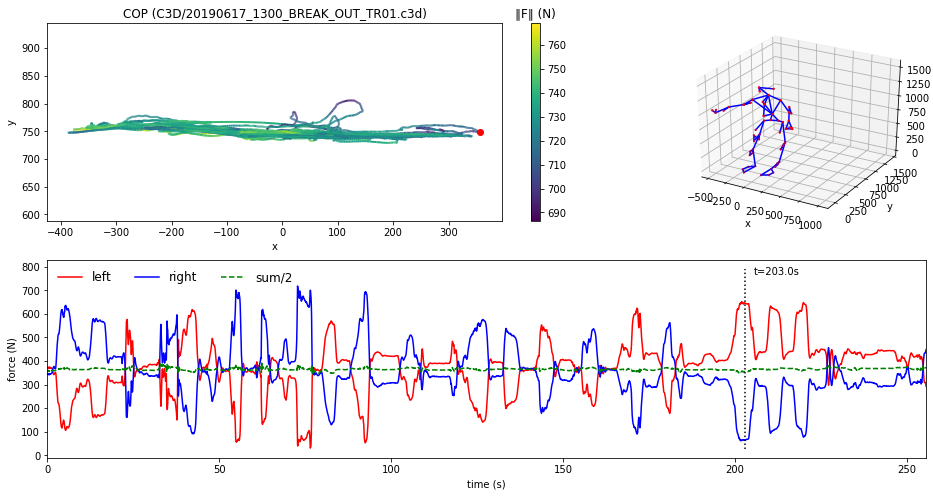

In [25]:
fm = cop[:, 2]
stress.print_force_range(fm)

frame_num = int(203*fs)

plt.clf()
plt.tight_layout()

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
stress.plot_cop(*cop.transpose(), frame_num=frame_num, markersize=12)
ax.set_title('COP (%10s)'%(filename))

ax = plt.subplot2grid((2, 3), (0, 2), projection='3d', frame_on=False)
#ax.scatter(*points[0,:,0:3].transpose(), color='g', zorder=0)
stress.plot_skel(skel_idx, points, frame_num=frame_num)
        
ax = plt.subplot2grid((2, 3), (1, 0), colspan=3)
stress.plot_force_plates(force, frame_num=frame_num, fs=fs)
        
fig = plt.gcf()
fig.set_size_inches(15.75, 8)
plt.show()